In [94]:
## Clean up training data, including correcting labels models think are wrong
import re
from bs4 import BeautifulSoup
import pandas as pd
from config import HOME_DIR

df = pd.read_csv(HOME_DIR+"/input/train.csv")

#text normalization/cleaning
df['text'] = df.text.str.lower().str.strip()
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
df['text'] = df['text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', '[USERNAME]', x))
df['text'] = df['text'].apply(lambda x: ''.join(ch for ch in x if ch.isascii()))
df['text'] = df['text'].str.replace(r'\n', ' ', regex=True) 
df['text'] = df['text'].str.replace(r'\s\s+', ' ', regex=True)  # To remove extra whitespaces
df['keyword'] = df['keyword'].str.replace(r'%20', ' ', regex=True) 
df['location'] = df['location'].apply(lambda x: ''.join(ch for ch in str(x) if ch.isascii()) if isinstance(x, str) else '')

#drop repeats of text with same target
df.drop_duplicates(subset=['text', 'target'], keep='last', inplace=True)
#remove duplicate texts with different targets
df.drop_duplicates(subset=['text'], inplace=True)

#correct labels
labeled_df = pd.read_csv(HOME_DIR+"/training_mislabelings.csv")
merged_df = pd.merge(df, labeled_df, on='id')
def update_target(row):
    if row['Predicted_0'] == 3:
        return 0
    elif row['Predicted_1'] == 3:
        return 1
    else:
        return row['target']

merged_df['target'] = merged_df.apply(update_target, axis=1)

merged_df[df.columns].to_csv(HOME_DIR+"/input/train_cln.csv", index=False)


/Users/christopherackerman/opt/anaconda3/envs/XCS224N/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [159]:
## Combine classifiers

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import os
import pandas as pd
import os
from itertools import combinations
import re

def load_data(directory_path):
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    # Initialize dataframe with first csv file
    file_name = csv_files[0]
    df = pd.read_csv(os.path.join(directory_path, file_name))
    df = df.drop_duplicates(keep='first')##adding this as a hack because openai ft join on text is matching multiple rows
    df.rename(columns={"predicted_label": re.sub(r'_[^_]*$', '',os.path.splitext(file_name)[0])}, inplace=True)

    # Create the additional features
    df["text_length"] = df["input_text"].apply(len)
    df["contains_username"] = df["input_text"].str.contains("\[USERNAME\]").astype(int)
    df["contains_url"] = df["input_text"].str.contains("\[URL\]").astype(int)
    df["contains_unknown"] = df["input_text"].str.contains("unknown").astype(int)
    df["contains_hashtag"] = df["input_text"].str.contains("#").astype(int)

    # Loop through the rest of the csv files
    for file_name in csv_files[1:]:
        df_temp = pd.read_csv(os.path.join(directory_path, file_name))
        df_temp = df_temp.drop_duplicates(keep='first')##adding this as a hack because openai ft join on text is matching multiple rows
        classifier_name = re.sub(r'_[^_]*$', '',os.path.splitext(file_name)[0])
        df = df.merge(df_temp[["id", "predicted_label"]].rename(columns={"predicted_label": classifier_name}), on="id", how='outer')

    # Replace missing values in df with 0
    df.fillna(0, inplace=True)

    return df

directory_path = HOME_DIR+'/Downloads/models/eval'
df = load_data(directory_path)
df.to_csv("classifer_debug_train.csv", index=False)

# Separate the features from the target
feature_cols = [c for c in df.columns if c not in ["id", "input_text", "true_label"]]
X_train = df[feature_cols].values
y = df["true_label"].values

# Use a logistic regression as the meta-classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, np.array(y))

directory_path = HOME_DIR+'/Downloads/models/'
df = load_data(directory_path)
df.to_csv("classifer_debug_test.csv", index=False)

# Separate the features from the target
X_test = df[feature_cols].values
y_test_pred = clf.predict(X_test)
output_df = pd.DataFrame({'id': df['id'], 'target': y_test_pred})
output_df.to_csv("submission.csv", index=False)

"""
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))#RandomForestClassifier())#

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f"Cross-validation score: {scores.mean():.4f}")
"""

'\nclf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))#RandomForestClassifier())#\n\n# Perform 5-fold cross-validation\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)\nscores = cross_val_score(clf, X, y, cv=cv, scoring=\'accuracy\')\n\nprint(f"Cross-validation score: {scores.mean():.4f}")\n'

Processing model: responses_gptfinetuned_aug_cln_valid
Processing model: openai_ada_encoder_noaug_logreg_eval
Processing model: gpt2-xl_encoder_aug_cls_logreg_eval
Processing model: roberta-large_aug_finetuned_classhead_eval_cln
Processing model: roberta-large_encoder_aug_cls_logreg_eval
Processing model: responses_aug_palm_eval_cln
Processing model: distilgpt2_aug_finetuned_eval_cln_nolabels_trainer
Processing model: flan-t5-large_aug_finetunedlora_classhead_eval_cln (1)
Majority vote accuracy 0.9095100864553314
number of models 8
max count of mistakes 8
Text: 1433, True label: 1, Models: ['responses_gptfinetuned_aug_cln_valid', 'openai_ada_encoder_noaug_logreg_eval', 'gpt2-xl_encoder_aug_cls_logreg_eval', 'roberta-large_aug_finetuned_classhead_eval_cln', 'roberta-large_encoder_aug_cls_logreg_eval', 'responses_aug_palm_eval_cln', 'distilgpt2_aug_finetuned_eval_cln_nolabels_trainer', 'flan-t5-large_aug_finetunedlora_classhead_eval_cln (1)']
Text: 598, True label: 1, Models: ['responses

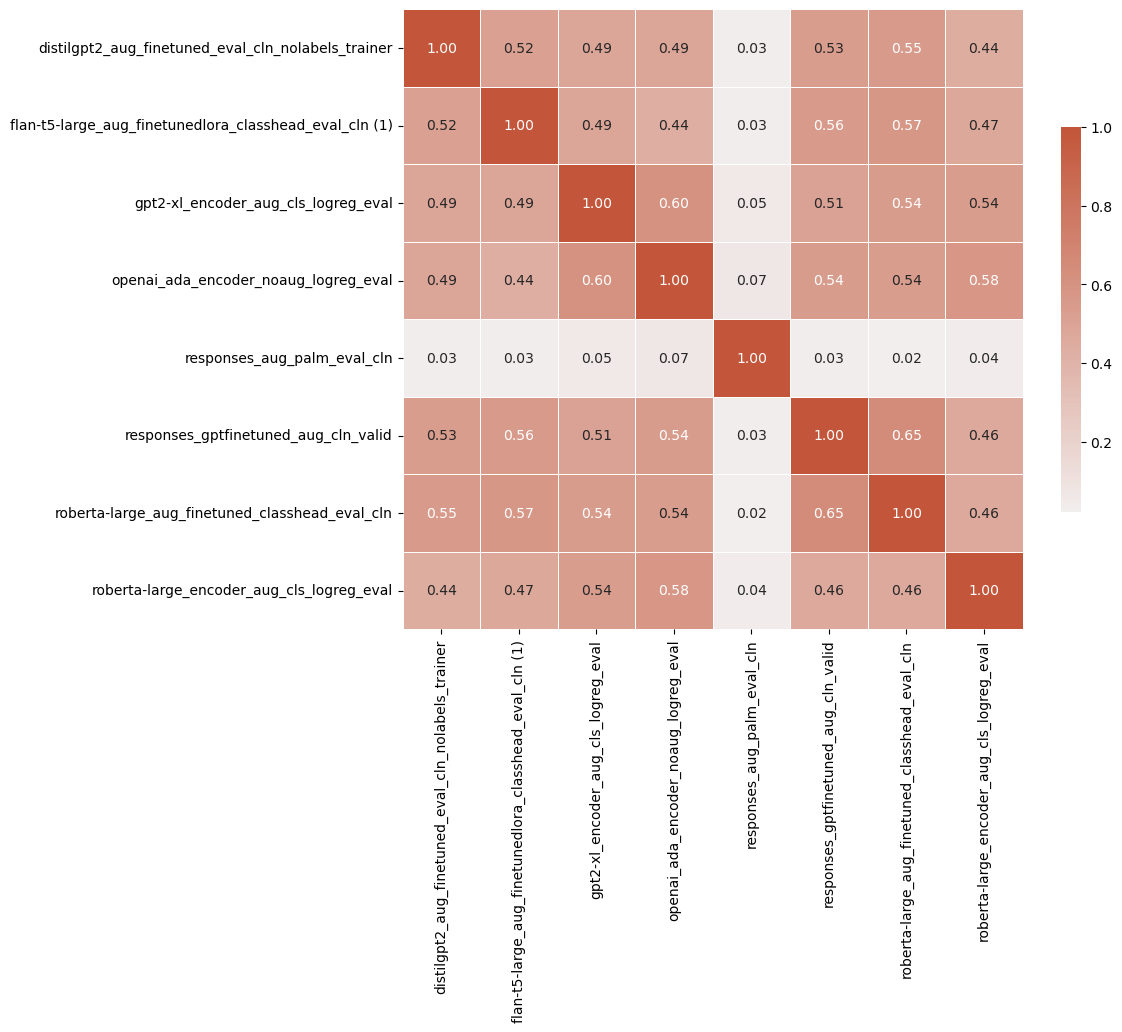

In [146]:
## Error analysis, majority vote, display correlations

#!pip3 install pandas
#!pip3 install openpyxl
#!pip3 install seaborn
import os
import pandas as pd
from collections import defaultdict
import re
from config import HOME_DIR

directory_path = HOME_DIR+'/Downloads/models/' 
files = os.listdir(directory_path)

tweet_stats = {}

corr_df = pd.DataFrame()
modelacc = {}

results = defaultdict(lambda: [0, 0,  None, None])  # To store text, count of 0 predictions, count of 1 predictions, true_label, and id

def sep_strip(s):
    return s.split('[sep]')[0].strip()

for filename in files:
    if filename.endswith('.csv'):  
        print(f"Processing model: {filename.replace('.csv', '')}")
        df = pd.read_csv(os.path.join(directory_path, filename))
        #clean up potential inconsistencies in input text between classifiers
        df['input_text'] = df['input_text'].str.replace(r'\n', ' ', regex=True)
        df['input_text'] = df['input_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', x))
        df['input_text'] = df['input_text'].str.lower().str.strip().str.replace("</s>", "[sep]", regex=False)
        df['input_text'] = df['input_text'].apply(sep_strip).str.replace("  ", " ", regex=False)
        df = df.sort_values('input_text')    
        df['predicted_label'] = df['predicted_label'].fillna(0)
        df['mistake'] = df['predicted_label'] != df['true_label']
        corr_df[filename.replace('.csv', '')] = df['mistake'].apply(lambda x: 1 if x else 0)
        mistakes = 0
        for index, row in df.iterrows():
            id = row['id']
            input_text = row['input_text']
            predicted_label = int(row['predicted_label'])
            true_label = row['true_label']
            # Increase the count of predictions
            results[id][predicted_label] += 1#results[input_text][predicted_label] += 1
            
            # Keep the true_label, this will overwrite each time but will always be the same
            results[id][2] = true_label#results[input_text][2] = true_label
            results[id][3] = row['input_text']#results[input_text][3] = row['id']

            if id not in tweet_stats:#if input_text not in tweet_stats:
                tweet_stats[id] = {'corcount': 0, 'miscount': 0, 'true_label': true_label, 'models': []}#tweet_stats[input_text] = {'corcount': 0, 'miscount': 0, 'true_label': true_label, 'models': []}
            if row['mistake']:
                if filename.replace('.csv', '') not in tweet_stats[id]['models']:#some model have dupe rows
                    tweet_stats[id]['miscount'] += 1
                    tweet_stats[id]['models'].append(filename.replace('.csv', ''))
                    mistakes += 1
            else:
                tweet_stats[id]['corcount'] += 1
        modelacc[filename.replace('.csv', '')] = (len(df) - mistakes) / len(df)

# Convert results to a DataFrame and save it as a CSV
output_df = pd.DataFrame.from_dict(results, orient='index', columns=['Predicted_0', 'Predicted_1', 'True_label', 'input_text'])
output_df.reset_index(inplace=True)
output_df.rename(columns={'index': 'Id'}, inplace=True)#output_df.rename(columns={'index': 'Input_text'}, inplace=True)
for index, row in output_df.iterrows():
    if row['Predicted_0'] >= row['Predicted_1']:
        output_df.at[index, 'Majority_vote'] = 0
    else:
        output_df.at[index, 'Majority_vote'] = 1

output_df.to_csv('majvote_output.csv', index=False)
print("Majority vote accuracy", (output_df['Majority_vote'] == output_df['True_label']).sum() / len(output_df))

maxwrong = max([data['miscount'] for data in tweet_stats.values()])
print("number of models", corr_df.shape[1])
print("max count of mistakes", maxwrong)
for text, data in tweet_stats.items():
    if data['miscount'] == maxwrong:
        print(f"Text: {text}, True label: {data['true_label']}, Models: {data['models']}")


import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
#sort by keys
corr_df = corr_df.reindex(sorted(corr_df.columns), axis=1)
corr_matrix = corr_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_matrix, cmap=cmap, vmax=1, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

